In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**전처리**

augmentation

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_datagen = ImageDataGenerator(rescale = 1./255, # 모든 이미지 원소값들을 255로 나누기
                                   rotation_range=25, # 0~25도 사이에서 임의의 각도로 원본이미지를 회전
                                   width_shift_range=0.05, # 0.05범위 내에서 임의의 값만큼 임의의 방향으로 좌우 이동
                                   height_shift_range=0.05, # 0.05범위 내에서 임의의 값만큼 임의의 방향으로 상하 이동
                                   zoom_range=0.2, # (1-0.2)~(1+0.2) => 0.8~1.2 사이에서 임의의 수치만큼 확대/축소
                                   horizontal_flip=True, # 좌우로 뒤집기                                   
                                   vertical_flip=False,
                                   fill_mode='nearest'
                                  )
valid_datagen = ImageDataGenerator(rescale = 1./255)

*batch_size와 steps_per_epoch(model fit할 때)를 곱한 값이 훈련 샘플 수 보다 작거나 같아야 합니다*

In [9]:
class PersonalColorData():
    def __init__(self, dir):
        self.datalist = []
        self.dataimage = []
        self.datalabel = []
        
        self.season_encoding = {'spring': 0, 'summer': 1, 'fall': 2, 'winter': 3}
        self.sex_encoding = {'male': 0, 'female': 1}

        for (root, directories, files) in os.walk(dir):
            for d in directories:
                encoding_info = d.split('_')
                if len(encoding_info) != 2: continue
                temp_datalist = []
                temp_datalabel = []
                for (root2, directories2, files2) in os.walk(os.path.join(root, d)):
                    for file2 in files2:
                        file_path2 = os.path.join(root2, file2)
                        if file_path2[-4:] == '.jpg':
                            temp_datalist.append(file_path2)
                            temp_datalabel.append((self.season_encoding[encoding_info[0]], self.sex_encoding[encoding_info[1]]))
                temp_datalist = temp_datalist * (350 // len(temp_datalist))
                temp_datalist = temp_datalist[:346]
                temp_datalabel = temp_datalabel * (350 // len(temp_datalabel))
                temp_datalabel = temp_datalabel[:346]

                self.datalist += temp_datalist 
                self.datalabel += temp_datalabel 

        for d in self.datalist:
            img = load_img(d, target_size=(128,128))
            image_array = np.array(img, dtype=object)
            self.dataimage.append(image_array)

        self.dataimage = np.array(self.dataimage)

    
    def __len__(self):
        return len(self.datalist)


data = PersonalColorData('/content/drive/MyDrive/res/dataset/')
valid = PersonalColorData('/content/drive/MyDrive/res/valid/')

In [10]:
train_generator = train_datagen.flow(data.dataimage, data.datalabel, batch_size=32)
valid_generator = valid_datagen.flow(valid.dataimage, valid.datalabel, batch_size=16)



In [11]:
for data_batch, labels_batch in train_generator:
  print('배치 데이터 크기:', data_batch.shape)
  print('배치 레이블 크기:', labels_batch.shape)
  break


배치 데이터 크기: (32, 128, 128, 3)
배치 레이블 크기: (32, 2)


**VGGNET**

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

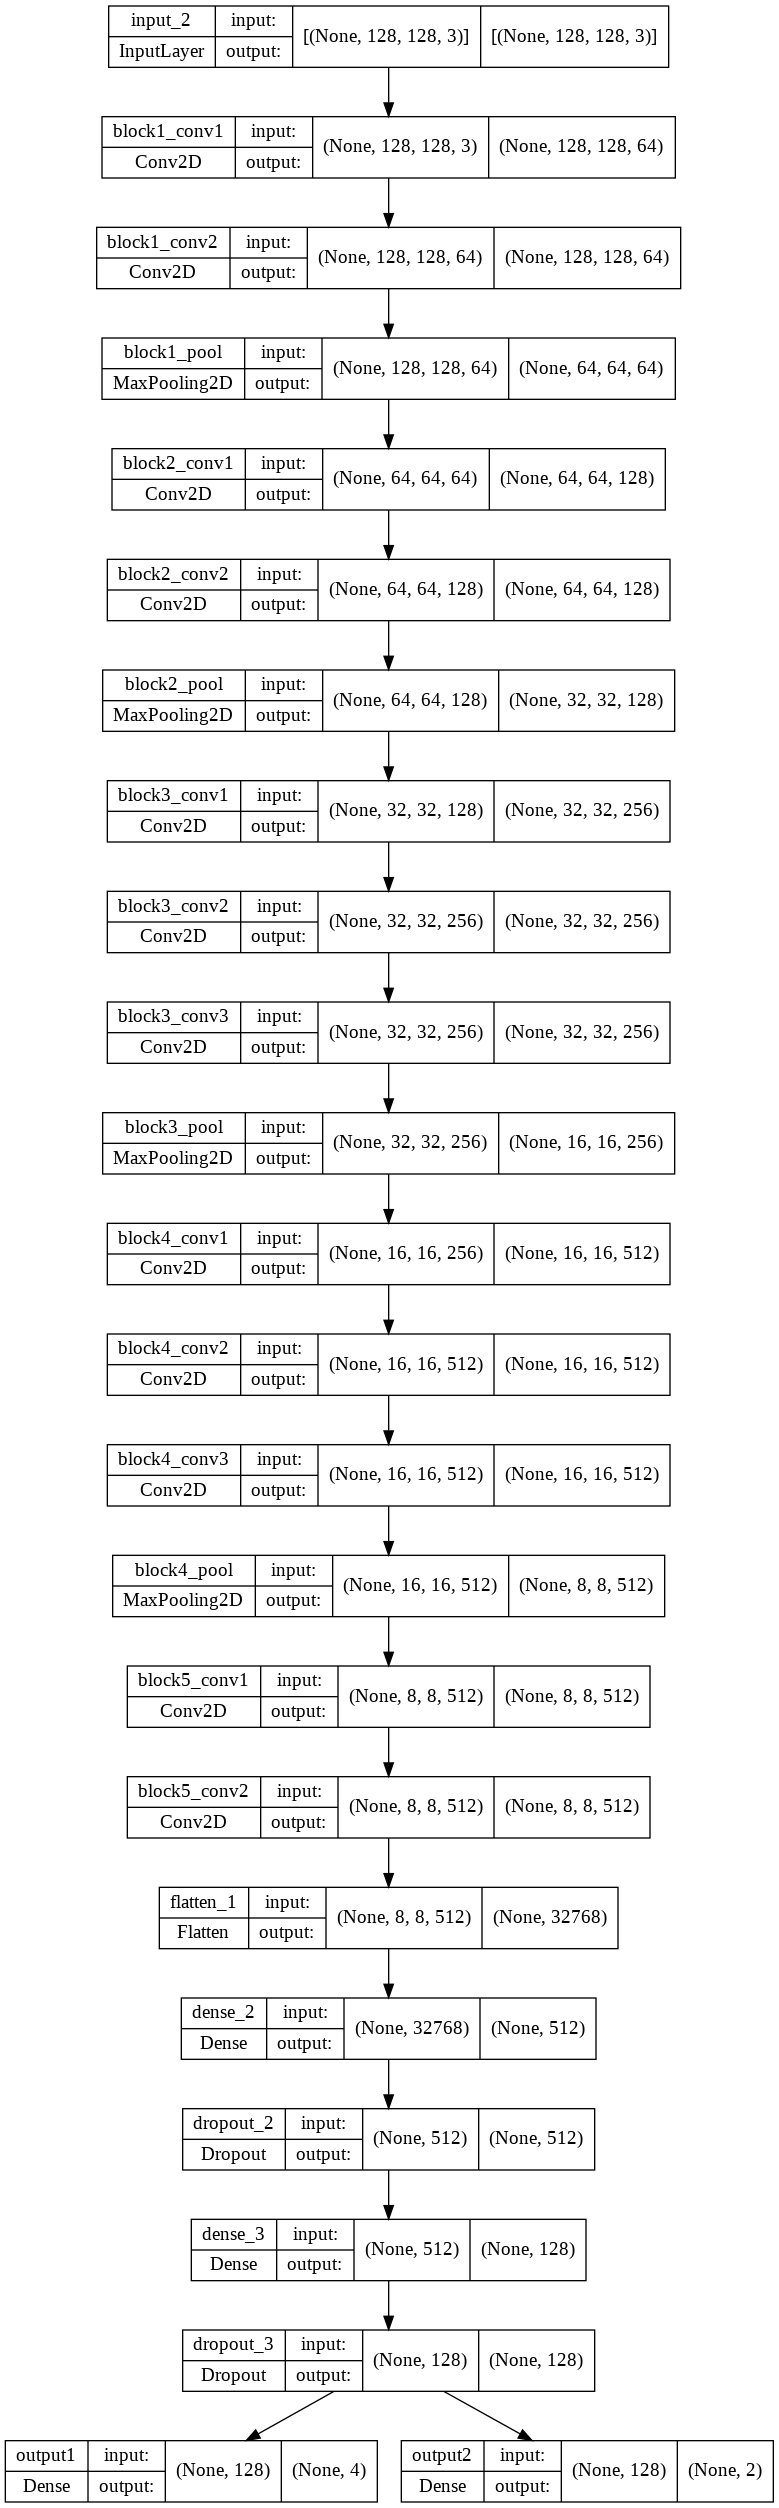

In [12]:
import tensorflow as tf
from tensorflow.keras import models , layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

pre_trained_vgg = VGG16(include_top=False, input_shape = (128,128,3), weights='imagenet')
pre_trained_vgg.trainable = True

for layer in pre_trained_vgg.layers[:7]:
    layer.trainable = False
# print(pre_trained_vgg.layers)
h = pre_trained_vgg.layers[16]

x = layers.Flatten()(h.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x1 = layers.Dense(4,activation='softmax', name='output1')(x)
x2 = layers.Dense(2,activation='softmax', name='output2')(x)

add_model = Model(inputs=pre_trained_vgg.inputs, outputs=[x1, x2])

add_model.summary()

tf.keras.utils.plot_model(add_model, show_shapes=True)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers, initializers , metrics
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import math
earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=20,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

checkpoint = ModelCheckpoint(filepath='model3.h5',
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True)

def step_decay(epoch):
    start = 0.0005
    drop = 0.8
    epochs_drop = 15.0
    lr = start * (drop ** np.floor((epoch)/epochs_drop))
    return lr
add_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adamax(),metrics=['acc'])
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
def three_way(gen):
    while True:
        x, y = gen.next()
        y1 = tf.keras.utils.to_categorical(y[:,0], 4)
        y2 = tf.keras.utils.to_categorical(y[:,1], 2)
        yield x, [y1,y2]

history = add_model.fit_generator(three_way(train_generator), # train_generator안에 X값, y값 다 있으니 generator만 주면 된다
                              validation_data=three_way(valid_generator),
                              steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size), # 한 번의 에포크(epoch)에서 훈련에 사용할 배치(batch)의 개수 지정; generator를 4번 부르겠다
                              epochs=100, # 데이터셋을 한 번 훈련하는 과정; epoch은 100 이상은 줘야한다
                              validation_steps=math.ceil(valid_generator.n / valid_generator.batch_size), # 한 번의 에포크가 끝날 때, 검증에 사용되는 배치(batch)의 개수를 지정; validation_generator를 4번 불러서 나온 이미지들로 작업을 해라
                              callbacks=[checkpoint,lr_scheduler,earlystopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/100
71/71 [==============================] - 18s 234ms/step - loss: 2.1230 - output1_loss: 1.4161 - output2_loss: 0.7069 - output1_acc: 0.2821 - output2_acc: 0.5167 - val_loss: 2.0785 - val_output1_loss: 1.3880 - val_output2_loss: 0.6905 - val_output1_acc: 0.2403 - val_output2_acc: 0.5059 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/100
71/71 [==============================] - 15s 220ms/step - loss: 2.0231 - output1_loss: 1.3821 - output2_loss: 0.6410 - output1_acc: 0.2839 - output2_acc: 0.6298 - val_loss: 1.9842 - val_output1_loss: 1.4238 - val_output2_loss: 0.5604 - val_output1_acc: 0.2564 - val_output2_acc: 0.7186 - lr: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005.
Epoch 3/100
71/71 [==============================] - 16s 222ms/step - loss: 1.8634 - output1_loss: 1.4113 - output2_loss: 0.4521 - output1_acc: 0.2901 - output2_acc: 0.8094 - 

**evaluate**

In [19]:
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

def load_image(filename):
	# Load the image
	img = load_img(filename, grayscale=False, target_size=(128, 128))
	# Convert the image to array
	img = img_to_array(img)
	# Reshape the image into a sample of 1 channel
	img = img.reshape(1,128,128,3)
	# Prepare it as pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

img = load_image('/content/drive/MyDrive/res/dataset/fall_female/fall_female100.jpg')

# Predict the apparel class
#class_prediction = model.predict_classes(img)
pred2, pred1 = add_model.predict(img)

print(pred1.argmax())
print(pred2.argmax())

pred1_class = pred1.argmax(axis=-1)
print(pred1_class[0])
list1 = ['Male', 'Female']
result1= list1[pred1_class[0]]
print(result1)

pred2_class = pred2.argmax(axis=-1)
print(pred2_class[0])
list2 = ['Spring', 'Summer', 'Fall','Winter']
result2= list2[pred2_class[0]]
print(result2)

result = result1+ result2
print(result)

1
2
1
Female
2
Fall
FemaleFall


In [16]:
add_model.evaluate(three_way(train_generator),steps=100)
add_model.evaluate(three_way(valid_generator), steps=100)

100/100 [==============================] - 3s 31ms/step - loss: 1.0197 - output1_loss: 0.7797 - output2_loss: 0.2401 - output1_acc: 0.8344 - output2_acc: 0.9688


[1.0197341442108154,
 0.7796532511711121,
 0.24008043110370636,
 0.8343750238418579,
 0.96875]

In [ ]:
# 정확도 및 손실 시각화
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

KeyError: ignored